# Device Proposal

YOLO (You Only Look Once) is one of the most popular deep learning-based object detection algorithms.
Yolov5 already allows us to create and train our own object detector. It is based on a neural network that divides the image into regions, predicting identification frames and probabilities for each region; The boxes are weighted based on the predicted probabilities. The algorithm learns generalizable representations of objects, allowing a low detection error for new inputs, different from the training data set.

We will use this algorithm in the functionallity of the robot arm. With this, the robot will be able to detect different types of objects and sort them by types.

### This code loads a pre-trained YOLOv5s model from PyTorch Hub as a model 

In [24]:
import torch
# acquisition of the Yolo5v Model
model = torch.hub.load('ultralytics/yolov5', 'yolov5s')  

Using cache found in C:\Users\glori/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2023-11-8 Python-3.11.7 torch-2.3.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


### Now we're going to use YOLOv5 in a scene in Coppelia Sim so that the robot is able to classify objects by images

In [25]:
import sim          # library to connect with CoppeliaSim
import sympy as sp  # library for symbolic calculation
import torch
import pandas
import time

import numpy as np              
import cv2
from  matplotlib import pyplot as plt
%matplotlib inline 

import cv2 
from matplotlib import pyplot as plt
from sympy.physics.vector import init_vprinting

import numpy as np
from sympy import *

%matplotlib inline

In [26]:
def connect(port):
# Establishes the connection to VREP
# port must match the connection port in VREP
# returns the client number or -1 if the connection cannot be established
    sim.simxFinish(-1) # just in case, close all opened connections
    clientID=sim.simxStart('127.0.0.1',port,True,True,2000,5) 
    if clientID == 0: print("connect to", port)
    else: print("Could not connect")
    return clientID

In [27]:
# We require the handlers for the joints, the suction cup and the suction sensor (Allows us to know if the object is close)
clientID = connect(19999)

retCode,tip=sim.simxGetObjectHandle(clientID,'suctionPadSensor',sim.simx_opmode_blocking)
retCode,suction=sim.simxGetObjectHandle(clientID,'suctionPad',sim.simx_opmode_blocking)
retCode,camera=sim.simxGetObjectHandle(clientID,'Vision_sensor',sim.simx_opmode_blocking)
retCode,joint1=sim.simxGetObjectHandle(clientID,'Joint1',sim.simx_opmode_blocking)
retCode,joint2=sim.simxGetObjectHandle(clientID,'Joint2',sim.simx_opmode_blocking)
retCode,joint3=sim.simxGetObjectHandle(clientID,'Joint3',sim.simx_opmode_blocking)

retCode,cuboid=sim.simxGetObjectHandle(clientID,'Cuboid[0]',sim.simx_opmode_blocking)
retCode,cuboid1=sim.simxGetObjectHandle(clientID,'Cuboid[1]',sim.simx_opmode_blocking)
retCode,cuboid2=sim.simxGetObjectHandle(clientID,'Cuboid[2]',sim.simx_opmode_blocking)
retCode,cuboid3=sim.simxGetObjectHandle(clientID,'Cuboid[3]',sim.simx_opmode_blocking)
retCode,cuboid4=sim.simxGetObjectHandle(clientID,'Cuboid[4]',sim.simx_opmode_blocking)
retCode,cuboid5=sim.simxGetObjectHandle(clientID,'Cuboid[5]',sim.simx_opmode_blocking)

print(tip, suction, joint1, joint2, joint3,cuboid,cuboid1,cuboid2 )

connect to 19999
24 22 17 19 21 0 0 0


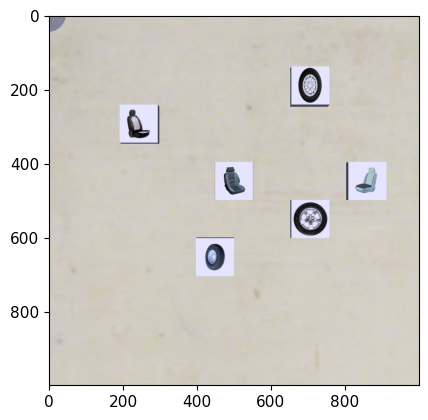

In [28]:
# We obtain the image from the Camera Sensor
retCode, resolution, image = sim.simxGetVisionSensorImage(clientID,camera,0,sim.simx_opmode_oneshot_wait)
img=np.array(image,dtype=np.uint8)
img.resize([resolution[1],resolution[0],3])
img = img[::-1, ::-1, :]
plt.imshow(img)
plt.show()

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'yolov5x6')

In [41]:
# Inference
results = model(img)

# Results
positions = results.pandas().xyxy[0]
positions

,xmin,ymin,xmax,ymax,confidence,class,name
0,659.995544,506.140564,752.334900,596.067078,0.895691,74,clock
1,828.727844,415.024780,886.624084,481.801514,0.850624,56,chair
2,658.072632,141.248703,752.927673,245.203445,0.795082,74,clock
3,421.890411,618.416199,474.638702,689.705933,0.647093,74,clock
4,472.860382,411.296478,530.275696,485.247620,0.633623,33,kite
5,211.536438,256.157166,273.186340,332.466949,0.416616,0,person
6,210.886841,255.258972,273.030029,333.807983,0.351974,56,chair
7,472.813416,411.363861,530.473145,485.598907,0.268475,56,chair


In [31]:
# We calculate the centers of each detection
positions["xcenter"] = [(positions["xmax"][i] - positions["xmin"][i])/2 + positions["xmin"][i] for i in range(len(positions))]
positions["ycenter"] = [(positions["ymax"][i] - positions["ymin"][i])/2 + positions["ymin"][i] for i in range(len(positions))]
positions

,xmin,ymin,xmax,ymax,confidence,class,name,xcenter,ycenter
0,659.995544,506.140564,752.334900,596.067078,0.895691,74,clock,706.165222,551.103821
1,828.727844,415.024780,886.624084,481.801514,0.850624,56,chair,857.675964,448.413147
2,658.072632,141.248703,752.927673,245.203445,0.795082,74,clock,705.500153,193.226074
3,421.890411,618.416199,474.638702,689.705933,0.647093,74,clock,448.264557,654.061066
4,472.860382,411.296478,530.275696,485.247620,0.633623,33,kite,501.568039,448.272049
5,211.536438,256.157166,273.186340,332.466949,0.416616,0,person,242.361389,294.312057
6,210.886841,255.258972,273.030029,333.807983,0.351974,56,chair,241.958435,294.533478
7,472.813416,411.363861,530.473145,485.598907,0.268475,56,chair,501.643280,448.481384


In [32]:
# Change the centers from 0-1000 to 0-0.5 to use the map coordinates

coords = np.array([[positions["xcenter"][i]*0.5/1000, positions["ycenter"][i]*0.5/1000] for i in range(len(positions))])
positions["x"] = coords[:, 0]
positions["y"] = coords[:, 1]
positions

,xmin,ymin,xmax,ymax,confidence,...,name,xcenter,ycenter,x,y
0,659.995544,506.140564,752.334900,596.067078,0.895691,...,clock,706.165222,551.103821,0.353083,0.275552
1,828.727844,415.024780,886.624084,481.801514,0.850624,...,chair,857.675964,448.413147,0.428838,0.224207
2,658.072632,141.248703,752.927673,245.203445,0.795082,...,clock,705.500153,193.226074,0.352750,0.096613
3,421.890411,618.416199,474.638702,689.705933,0.647093,...,clock,448.264557,654.061066,0.224132,0.327031
4,472.860382,411.296478,530.275696,485.247620,0.633623,...,kite,501.568039,448.272049,0.250784,0.224136
5,211.536438,256.157166,273.186340,332.466949,0.416616,...,person,242.361389,294.312057,0.121181,0.147156
6,210.886841,255.258972,273.030029,333.807983,0.351974,...,chair,241.958435,294.533478,0.120979,0.147267
7,472.813416,411.363861,530.473145,485.598907,0.268475,...,chair,501.643280,448.481384,0.250822,0.224241


In [33]:
# Delete all necessary data

detections = positions.drop(columns=["xmin", "ymin", "xmax", "ymax", "confidence", "class", "xcenter", "ycenter"])
detections

,name,x,y
0,clock,0.353083,0.275552
1,chair,0.428838,0.224207
2,clock,0.352750,0.096613
3,clock,0.224132,0.327031
4,kite,0.250784,0.224136
5,person,0.121181,0.147156
6,chair,0.120979,0.147267
7,chair,0.250822,0.224241


In [34]:
detections_list = detections.values.tolist()
detections_list

[['clock', 0.35308261108398437, 0.2755519104003906],
 ['chair', 0.4288379821777344, 0.22420657348632814],
 ['clock', 0.35275007629394534, 0.096613037109375],
 ['clock', 0.22413227844238282, 0.3270305328369141],
 ['kite', 0.25078401947021484, 0.22413602447509764],
 ['person', 0.12118069458007813, 0.1471560287475586],
 ['chair', 0.12097921752929687, 0.14726673889160155],
 ['chair', 0.25082164001464846, 0.22424069213867187]]

In [35]:
# Calculate the angels of the joints with inverse kinematics
init_vprinting(use_latex='mathjax', pretty_print=False)

from sympy.physics.mechanics import dynamicsymbols
theta1, theta2, la, lb, theta, alpha, a, d = dynamicsymbols('theta1 theta2 la lb theta alpha a d')
theta1, theta2, la, lb, theta, alpha, a, d

(theta1, theta2, la, lb, theta, alpha, a, d)

In [36]:
# I calculate the matrix homogenies

rot = sp.Matrix([[sp.cos(theta), -sp.sin(theta)*sp.cos(alpha), sp.sin(theta)*sp.sin(alpha)],
                 [sp.sin(theta), sp.cos(theta)*sp.cos(alpha), -sp.cos(theta)*sp.sin(alpha)],
                 [0, sp.sin(alpha), sp.cos(alpha)]])

trans = sp.Matrix([a*sp.cos(theta),a*sp.sin(theta),d])

last_row = sp.Matrix([[0, 0, 0, 1]])

m = sp.Matrix.vstack(sp.Matrix.hstack(rot, trans), last_row)

m01 = m.subs({ theta:theta1, d:0, a:la , alpha:0})
m12 = m.subs({ theta:theta2, d:0, a:lb , alpha:0})

m02 = (m01*m12)
mbee= sp.Matrix([[sp.trigsimp(m02[0,0].simplify()), sp.trigsimp(m02[0,1].simplify()), sp.trigsimp(m02[0,2].simplify()),sp.trigsimp(m02[0,3].simplify())],
                 [sp.trigsimp(m02[1,0].simplify()), sp.trigsimp(m02[1,1].simplify()), sp.trigsimp(m02[1,2].simplify()),sp.trigsimp(m02[1,3].simplify())],
                 [m02[2,0].simplify(), m02[2,1].simplify(), m02[2,2].simplify(),m02[2,3].simplify()],
                 [m02[3,0].simplify(), m02[3,1].simplify(), m02[3,2].simplify(),m02[3,3].simplify()]])

mbee

Matrix([
[cos(theta1 + theta2), -sin(theta1 + theta2), 0, la*cos(theta1) + lb*cos(theta1 + theta2)],
[sin(theta1 + theta2),  cos(theta1 + theta2), 0, la*sin(theta1) + lb*sin(theta1 + theta2)],
[                   0,                     0, 1,                                        0],
[                   0,                     0, 0,                                        1]])

In [37]:
def compute(p): # Calculate IK function
    eq1 = 0.3 * cos(theta1) + 0.3 * cos(theta1 + theta2) - p[0]
    eq2 = 0.3 * sin(theta1) + 0.3 * sin(theta1 + theta2) - p[1]
    q = nsolve((eq1,eq2),(theta1,theta2),(1,1))
    return q

def move(q): # Move joint0 & joint1  function
    retCode = sim.simxSetJointTargetPosition(clientID, joint1, q[0], sim.simx_opmode_oneshot)
    retCode = sim.simxSetJointTargetPosition(clientID, joint2, q[1], sim.simx_opmode_oneshot)
    
def setEffector(val):
# function that triggers the end effector remotely
# val is Int with value 0 or 1 to disable or activate the final actuator.
    res,retInts,retFloats,retStrings,retBuffer=sim.simxCallScriptFunction(clientID,
        "suctionPad", sim.sim_scripttype_childscript,"setEffector",[val],[],[],"", sim.simx_opmode_blocking)
    return res

def down(): # Down Manipulator function
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, -0.095, sim.simx_opmode_oneshot)
     
def up(): # Up Manipulator function
    retCode = sim.simxSetJointTargetPosition(clientID, joint3, 0, sim.simx_opmode_oneshot)

### In this part we will be able to stack the wheels and seats in different places 

In [38]:
# We create a function to obtaining the coordinates from the wheels and from the seats in two separated lists.

def obteain_coords(detections_list, object):
    coords = []
    for detection in lista_detections:
        if detection[0] == object:
            coords.append([detection[1], detection[2]])
    return coords

# We select only the classes that we want, in this case the wheel and the seat.
wheel_coords = obteain_coords(lista_detections, 'clock') # In this it doesn't detect the wheels as 'wheel', since the yolo doesn't have many classes
seat_coords = obteain_coords(lista_detections, 'chair')

print("Wheels Coordinates:", wheel_coords)
print("\Seats Coordinates:", seat_coords)

Wheels Coordinates: [[0.35308261108398437, 0.2755519104003906], [0.35275007629394534, 0.096613037109375], [0.22413227844238282, 0.3270305328369141]]
\Seats Coordinates: [[0.4288379821777344, 0.22420657348632814], [0.12097921752929687, 0.14726673889160155], [0.25082164001464846, 0.22424069213867187]]


In [39]:
# We chose the first elements of both piles

wheel_destiny = wheel_coords[0]
seat_destiny = seat_coords[0]

In [40]:
#Function to perform the apilation

def pile(piece1,destiny):
    
    qpiece1 = compute(piece1)
    qdestiny = compute(destiny)
    
    time.sleep(2)
    
    move(qpiece1)
    time.sleep(2)
    
    down()
    time.sleep(2)
    
    setEffector(1)
    
    up()
    time.sleep(2)
    
    move(qdestiny)
    time.sleep(2)
    
    setEffector(0)

In [42]:
# We create two loops to apilate the wheels and the seats.

for i in range(len(wheel_coords)-1):
    i = i+1
    pile(wheel_coords[i],wheel_destiny)
    
    
for i in range(len(seat_coords)-1):
    i = i+1
    pile(seat_coords[i],seat_destiny)